# Interaction importance on the Wisconsin Breast Cancer Dataset and comparison with with SHAP

In this example, a polynomial SVM is trained on the Wisconsin breast canser dataset [0] and the interactions of the resulting model is retrieved using ExplainPolySVM. Hyperparameters are tuned using 5-fold crossvalidation and a test performance is evaluated on a held-out, randomly selected test set.

To compare importance of the interactions, we normalize each feature to zero mean and unit variance.

Local explanations are compared to estimated SHAP values.

[0] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. 

In [ ]:
import numpy as np
import itertools
import time

from explainpolysvm import expsvm
from explainpolysvm.plot import waterfall
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

import shap
import skexplain

In [ ]:
# Set to True to store figures in ./images
save_figs = False

In [3]:
data = load_breast_cancer()

In [4]:
rng = np.random.default_rng(1011)
X = data['data']
y = data['target']
f_names = data['feature_names']
y_names = data['target_names']

# In dataset, targets y are in {0,1}. We replace 0 with -1 to conform with standard SVM nomenclature
y[y==0] = -1

# Create dictionary mapping index of features to their names. Used for plotting.
f_name_dict = {str(num):name for num, name in enumerate(f_names)}
f_name_dict['constant'] = 'constant'  # Add constant to feature name dictionary

In [5]:
# Hyperparameters to sweep
Cs = np.arange(0.1, 2.2, 0.2)
ds = [1, 2, 3, 4]
rs = np.arange(0, 3.5, 0.5)

Split dataset into training, validation and test sets.

Then, normalize all three sets by the mean and standard deviation of the training set (standardization).

Finally, run hyperparameter sweep.

In [6]:
gamma = 'scale'
kernel = 'poly'

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Set up 5-fold crossvalidation
k = 5
n_train = X_train.shape[0]
fold_labels = rng.permutation(np.repeat(np.arange(k), np.ceil(n_train/k)))[0:n_train]

# Results array from hyperparameter sweep, columns are [C, d, r, acc]
res = np.zeros((len(Cs)*len(ds)*len(rs),4))

ind = 0
for C in Cs:
    for d in ds:
        for r in rs:
            n_correct = 0
            for fold in np.arange(k):
                # Get fold training and validation sets
                X_train_fold = X_train[fold_labels!=fold]
                y_train_fold = y_train[fold_labels!=fold]
                X_val_fold = X_train[fold_labels==fold]
                y_val_fold = y_train[fold_labels==fold]
                
                # Standardize data
                scaler = StandardScaler()
                scaler.fit(X_train_fold)
                X_train_fold = scaler.transform(X_train_fold)
                X_val_fold = scaler.transform(X_val_fold)
                
                # Train SVC
                model = SVC(C=C, kernel=kernel, degree=d, gamma=gamma, coef0=r, probability=True)
                model.fit(X_train_fold, y_train_fold)

                # Predict validation set and couont number of correct predictions
                y_pred_fold = model.predict(X_val_fold)
                n_correct_fold = np.sum(y_val_fold==y_pred_fold)
                
                # Collect results
                n_correct += n_correct_fold
            
            # Collect used hyperparameters and go to next iteration
            res[ind,:] = np.array([C, d, r, n_correct/n_train])
            ind += 1
            

# Extract best hyperparameters
ind_best = np.argmax(res[:,3])
C_best, d_best, r_best, acc_best = res[ind_best, :]
d_best = int(d_best)  # Convert back to integer
print('Best hyperparameters found: C={:.1f}, d={}, r={}. 5-fold val. accuracy {:.3f}'.format(C_best, d_best, r_best, acc_best))

Best hyperparameters found: C=0.5, d=2, r=2.5. 5-fold val. accuracy 0.976


Retrain model with the combined training and validation sets, using the best hyperparameter combination, and evaluate on test set.

In [7]:
# Standardize training and test data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

# Fit SVM
model = SVC(C=C_best, kernel=kernel, degree=d_best, gamma=gamma, coef0=r_best, probability=True)
model.fit(X_train_scale, y_train)

# Test accuracy
test_acc = model.score(X_test_scale, y_test)
print('Test accuracy: {:.5f}'.format(test_acc))

Test accuracy: 0.97368


# Convert SVM with ExpSVM

In [8]:
t_start = time.time()
sv = model.support_vectors_
dual_coef = np.squeeze(model.dual_coef_)
intercept = model.intercept_[0]
kernel_gamma = model._gamma

es = expsvm.ExPSVM(sv=sv, dual_coef=dual_coef, intercept=intercept,
                   kernel_d=d_best, kernel_r=r_best, kernel_gamma=kernel_gamma,
                   feature_names=f_names)
es.transform_svm()
print(f"Time to calculate interaction importance: {time.time() - t_start:.3e}")

Time to calculate interaction importance: 2.000e-03


In [9]:
# Verify that performance has not changed (significantly) in the conversion.
y_pred = np.sign(es.decision_function(x=X_test_scale))
expsvm_acc = np.sum(y_pred==y_test)/y_test.size
print('Test accuracy with ExpSVM: {:.5f}. Difference between SVC and ExpSVM (SVC_acc-ExpSVM_acc) on test accuracy: {:.2e}'.format(expsvm_acc, test_acc-expsvm_acc))

Test accuracy with ExpSVM: 0.97368. Difference between SVC and ExpSVM (SVC_acc-ExpSVM_acc) on test accuracy: 0.00e+00


# Interaction importance

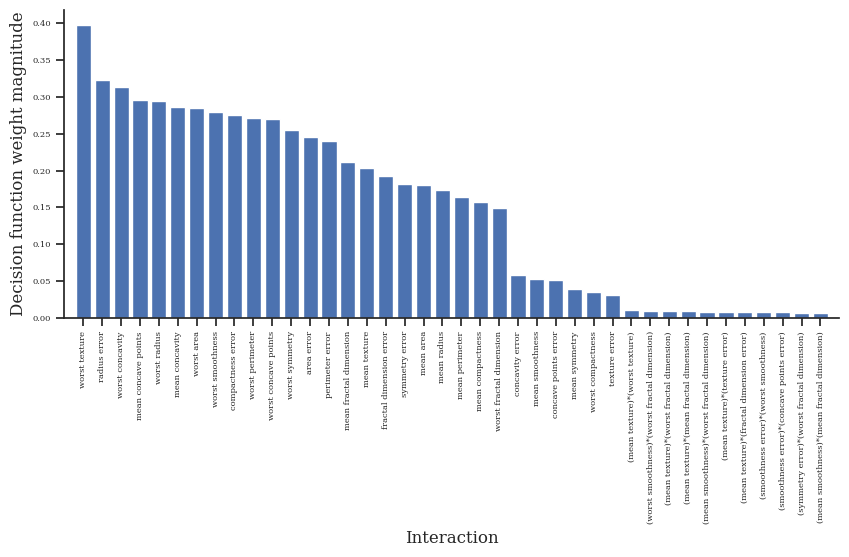

In [10]:
fig = es.plot_model_bar(n_features=40, magnitude=True, figsize=(10,4), show=False)
fig.gca().set_title('')
if save_figs:
    plt.savefig('./images/feature_importance_wbcd.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/feature_importance_wbcd.eps', bbox_inches='tight', facecolor='white')
fig.show(warn=False)

Plot signed importance

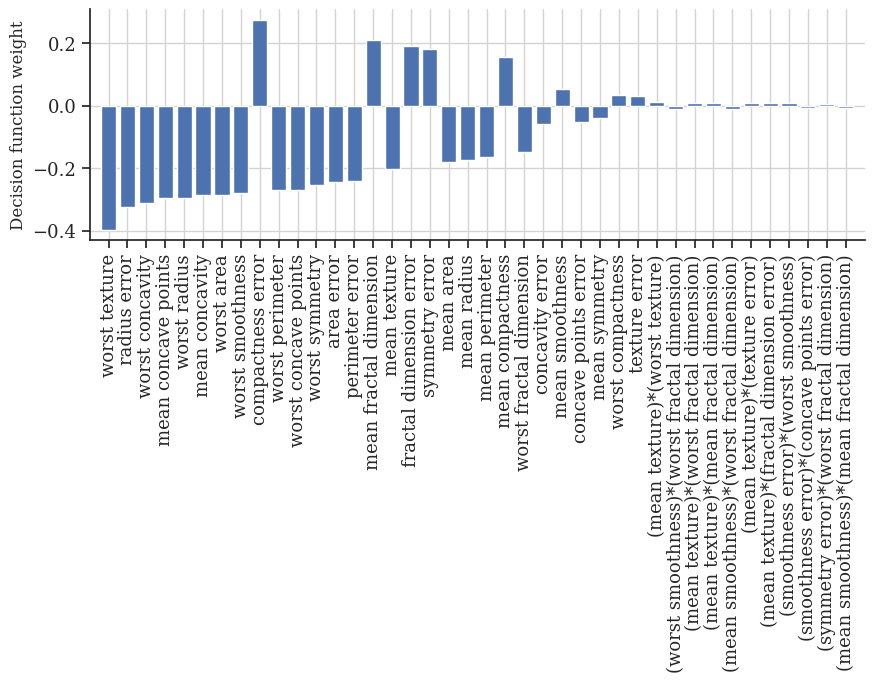

In [12]:
fig = es.plot_model_bar(n_features=40, magnitude=False, figsize=(10,3), show=False)
# fig.gca().grid(alpha=1)
fig.gca().set_axisbelow(True)
fig.gca().grid(color='lightgray')
fig.gca().tick_params(axis='both', labelsize=13)
fig.gca().set_title('')
fig.gca().set_xlabel('')
if save_figs:
    plt.savefig('./images/feature_importance_signed_wbcd.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/feature_importance_signed_wbcd.eps', bbox_inches='tight', facecolor='white')
fig.show(warn=False)

Since the feature can take both positive and negative values, we cannot directly say if the sign of the contribution to the decision function push the classification toward a positive or negative label. For this we need to know the typical values for positive and negative samples

Investigate decision function components for a single negative observation and positive observation, respectively.

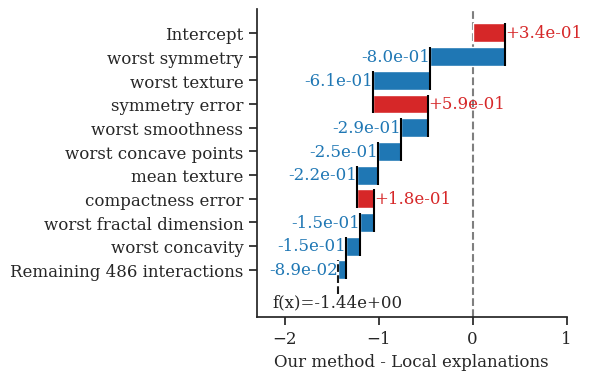

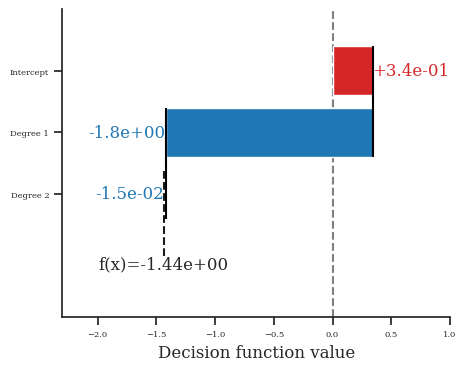

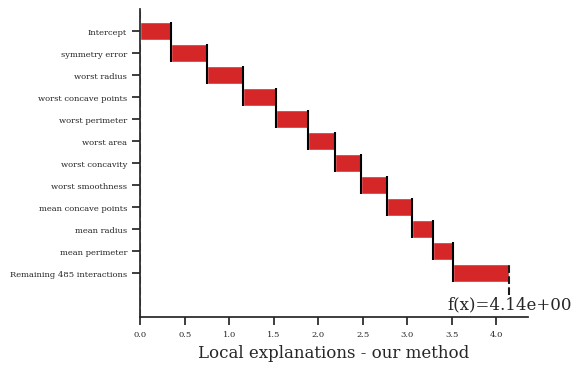

In [ ]:
# Negative sample
neg_ind = np.where(y_test==-1)[0][3]
x = X_test_scale[neg_ind,:]

# Plot interaction importance
fig = es.plot_sample_waterfall(x, n_features=9, show=False, show_values=True, show_sum=True, figsize=(4,4), xlim=[-2.3, 1])
# fig.gca().set_title('Interaction contribution in a single negative sample')
fig.gca().set_xlabel('Our method - Local explanations')
fig.gca().tick_params(axis='both', labelsize=12)
if save_figs:
    plt.savefig('./images/feature_importance_single_negative_wbcd.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/feature_importance_single_negative_wbcd.eps', bbox_inches='tight', facecolor='white')
fig.show(warn=False)

# Plot degree importance
fig = es.plot_sample_waterfall_degree(x, n_degree=2, show=False, show_values=True, show_sum=True, figsize=(5,4), xlim=[-2.3, 1])
# fig.gca().set_title('Degree contribution in a single negative sample')
if save_figs:
    plt.savefig('./images/degree_importance_single_negative_wbcd.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/degree_importance_single_negative_wbcd.eps', bbox_inches='tight', facecolor='white')
fig.show(warn=False)


# Positive sample
pos_ind = np.where(y_test==1)[0][0]
x = X_test_scale[pos_ind,:]

# Plot interaction importance
fig = es.plot_sample_waterfall(x, n_features=10, show=False, show_sum=True)
fig.gca().set_xlabel('Local explanations - our method')
if save_figs:
    plt.savefig('./images/feature_importance_single_positive_wbcd.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/feature_importance_single_positive_wbcd.eps', bbox_inches='tight', facecolor='white')

In [13]:
model.decision_function(X_test_scale[neg_ind:neg_ind+1,:])

array([-1.43559054])

Next, we calculate the contributions to the decision for each interaction for all positive and negative samples separately. The interactions are ordered in descending order from the interaction with the highest coefficient in the decision function, to the lowest. The top 50 interactions are shown.

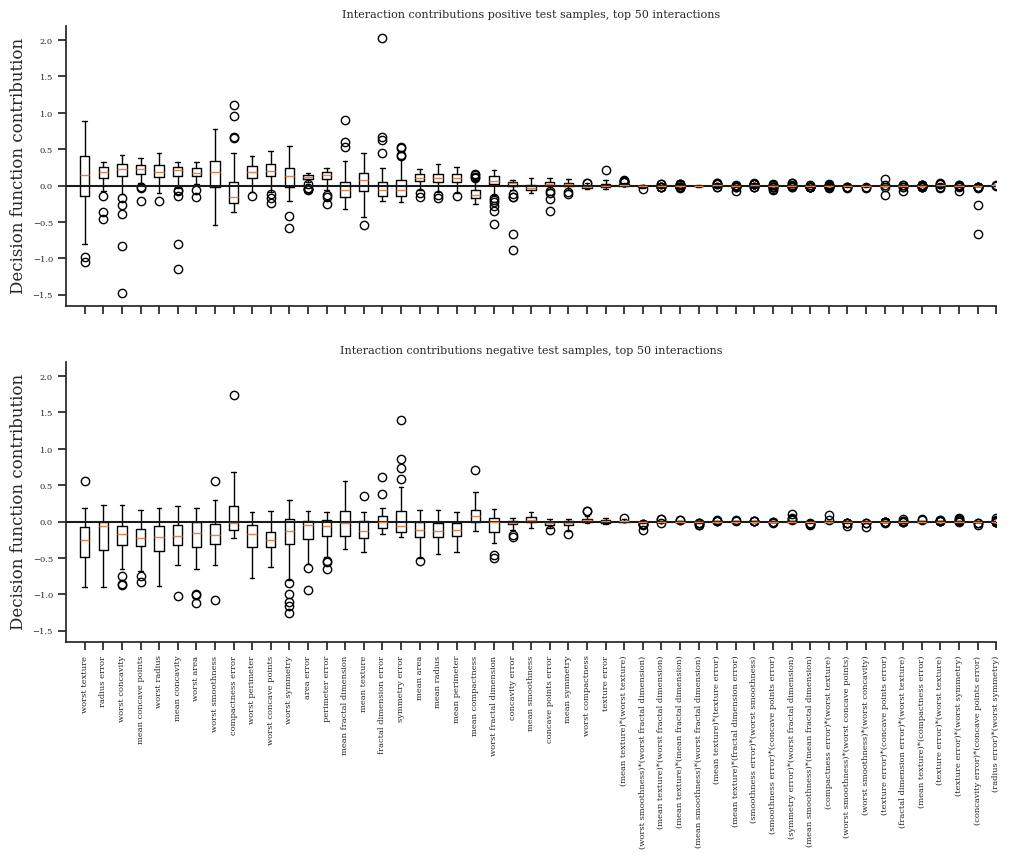

In [14]:
_, feat_names_magnitude, _ = es.feature_importance(include_intercept=False)
y_comp, feat_names = es.decision_function_components(x=X_test_scale, output_interaction_names=True, include_intercept=False)

# Include only the top 50 interactions
n_feat_plot = 50
top_interaction_ind = np.in1d(feat_names, feat_names_magnitude[0:n_feat_plot])

y_comp = y_comp[:,top_interaction_ind]
feat_names = feat_names[top_interaction_ind]

# Sort interactions according to the magnitude in the decision function
idx1 = np.argsort(feat_names_magnitude[0:n_feat_plot])
idx2 = np.argsort(feat_names)
idx1_inv = np.argsort(idx1)
y_comp = y_comp[:, idx2][:,idx1_inv]
feat_names = feat_names[idx2][idx1_inv]

# Rename ExpSVM interactions with real feature names
interaction_names = es.format_interaction_names(feat_names)

# Plot boxplots f the contributions to the decision function
fig, axs = plt.subplots(2,1, figsize=(12,8), sharex=True, sharey=True)
axs[0].boxplot(x=y_comp[y_test==1,:])
axs[0].hlines(xmin=0, xmax=n_feat_plot, y=0, color='k')
axs[0].set_title('Interaction contributions positive test samples, top {} interactions'.format(n_feat_plot))
axs[0].set_ylabel('Decision function contribution')

axs[1].boxplot(x=y_comp[y_test==-1,:])
axs[1].hlines(xmin=0, xmax=n_feat_plot, y=0, color='k')
axs[1].set_title('Interaction contributions negative test samples, top {} interactions'.format(n_feat_plot))
axs[1].set_ylabel('Decision function contribution')
plt.xticks(ticks=np.arange(len(interaction_names))+1, labels=interaction_names, rotation=90)
plt.xlim([0,n_feat_plot])
if save_figs:
    plt.savefig('./images/feature_importance_boxplot_contribution.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/feature_importance_boxplot_contribution.eps', bbox_inches='tight', facecolor='white')
plt.show()

# Mask SVM to only include linear features

In [15]:
es.interaction_mask

array([], dtype=float64)

In [16]:
es.set_mask(interaction_strs=[str(f) for f in np.arange(X.shape[1])])
# es.force_mask=True
y_pred_masked = np.sign(es.decision_function(x=X_test_scale, mask=True))
acc_masked = np.sum(y_pred_masked==y_test)/y_test.size
n_interaction = es.feature_importance(include_intercept=False)[0].size
print(f'Test accuracy using linear interactions {100*acc_masked:.1f}%, compared to {100*test_acc:.1f}% with all {n_interaction} features and interactions.')

Test accuracy using linear interactions 98.2%, compared to 97.4% with all 495 features and interactions.


# Compare most important interactions to linear SVM

Compare the top-10 linear interactions between the quadratic SVM with explanations from ExPSVM with the top 10 interactions from a linear SVM trained with the same C and gamma.

We compare by calculating the Rank Biased Overlap with p=0.9 (https://dl.acm.org/doi/10.1145/1852102.1852106) between the features.

Mean AO: 0.350 (std 0.104)


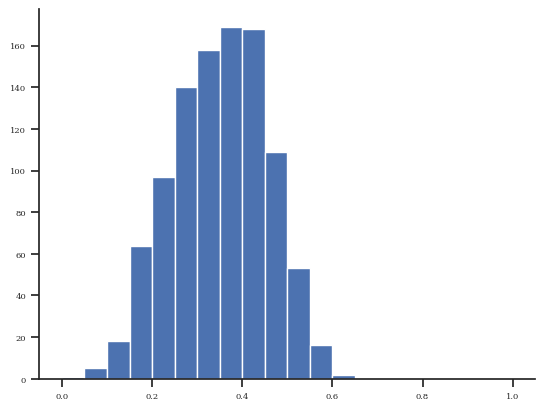

In [ ]:
# Compare the top-N features

n_features_compare = 10
n_tries = 1000
p = 0.9

feat_importance, feat_names, sort_order = es.feature_importance(format_names=True,
                                                       magnitude=True,
                                                       include_intercept=False, 
                                                       sort=True)
top10_important = sort_order[0:n_features_compare]

scaler = StandardScaler()

data = load_breast_cancer()
X, y = data.data, data.target

rbos = []
for n_try in np.arange(n_tries):
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    clf = SVC(kernel='linear', C=C_best, gamma='scale')
    clf.fit(X_train, y_train)

    importance_sorted_idx = np.argsort(np.abs(clf.coef_[0]))[::-1][0:n_features_compare]

    # Compare with ExpSVM
    rbo = []
    for d in np.arange(1,n_features_compare):
        frac_overlap = (p**(d-1))*len(set(sort_order[0:d]).intersection(set(importance_sorted_idx[0:d])))/d
        rbo.append(frac_overlap)
    rbos.append(np.mean(rbo))
    
print('Mean AO: {:.3f} (std {:.3f})'.format(np.mean(rbos), np.std(rbos)))
delta = 0.05
plt.hist(rbos, bins=np.arange(0,1+delta, delta))
plt.show()

We typically arrive at a average overlap around 0.35, meaning the two models produce similar lists but not in the same order

# Verify That model has no interactions with H-statistics

In [ ]:
f_names_comb = list(itertools.combinations(f_names, r=2))
explainer = skexplain.ExplainToolkit(estimators=('svc', model), X=X_train_scale, y=y_train, feature_names=f_names, estimator_output='probability')

In [ ]:
# Calculate and time PDP and Friedman's H-statistic without subsampling
t_start = time.time()
pd_1d_ds = explainer.pd(features=f_names,
                        n_bootstrap=1,
                        subsample=1,
                        n_jobs=12,
                        n_bins=50, 
                        )

pd_2d_ds = explainer.pd(features=f_names_comb, n_bins=50, subsample=1, n_bootstrap=1, n_jobs=12)

hstat_results = explainer.friedman_h_stat(pd_1d=pd_1d_ds, pd_2d=pd_2d_ds, features=f_names_comb,)
print(f'Time for H-statistic explanations: {time.time() - t_start:.3e}s')

100%|██████████| 435/435 [00:00<00:00, 14031.01it/s]

Time for H-statistic explanations: 3.553e+02s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


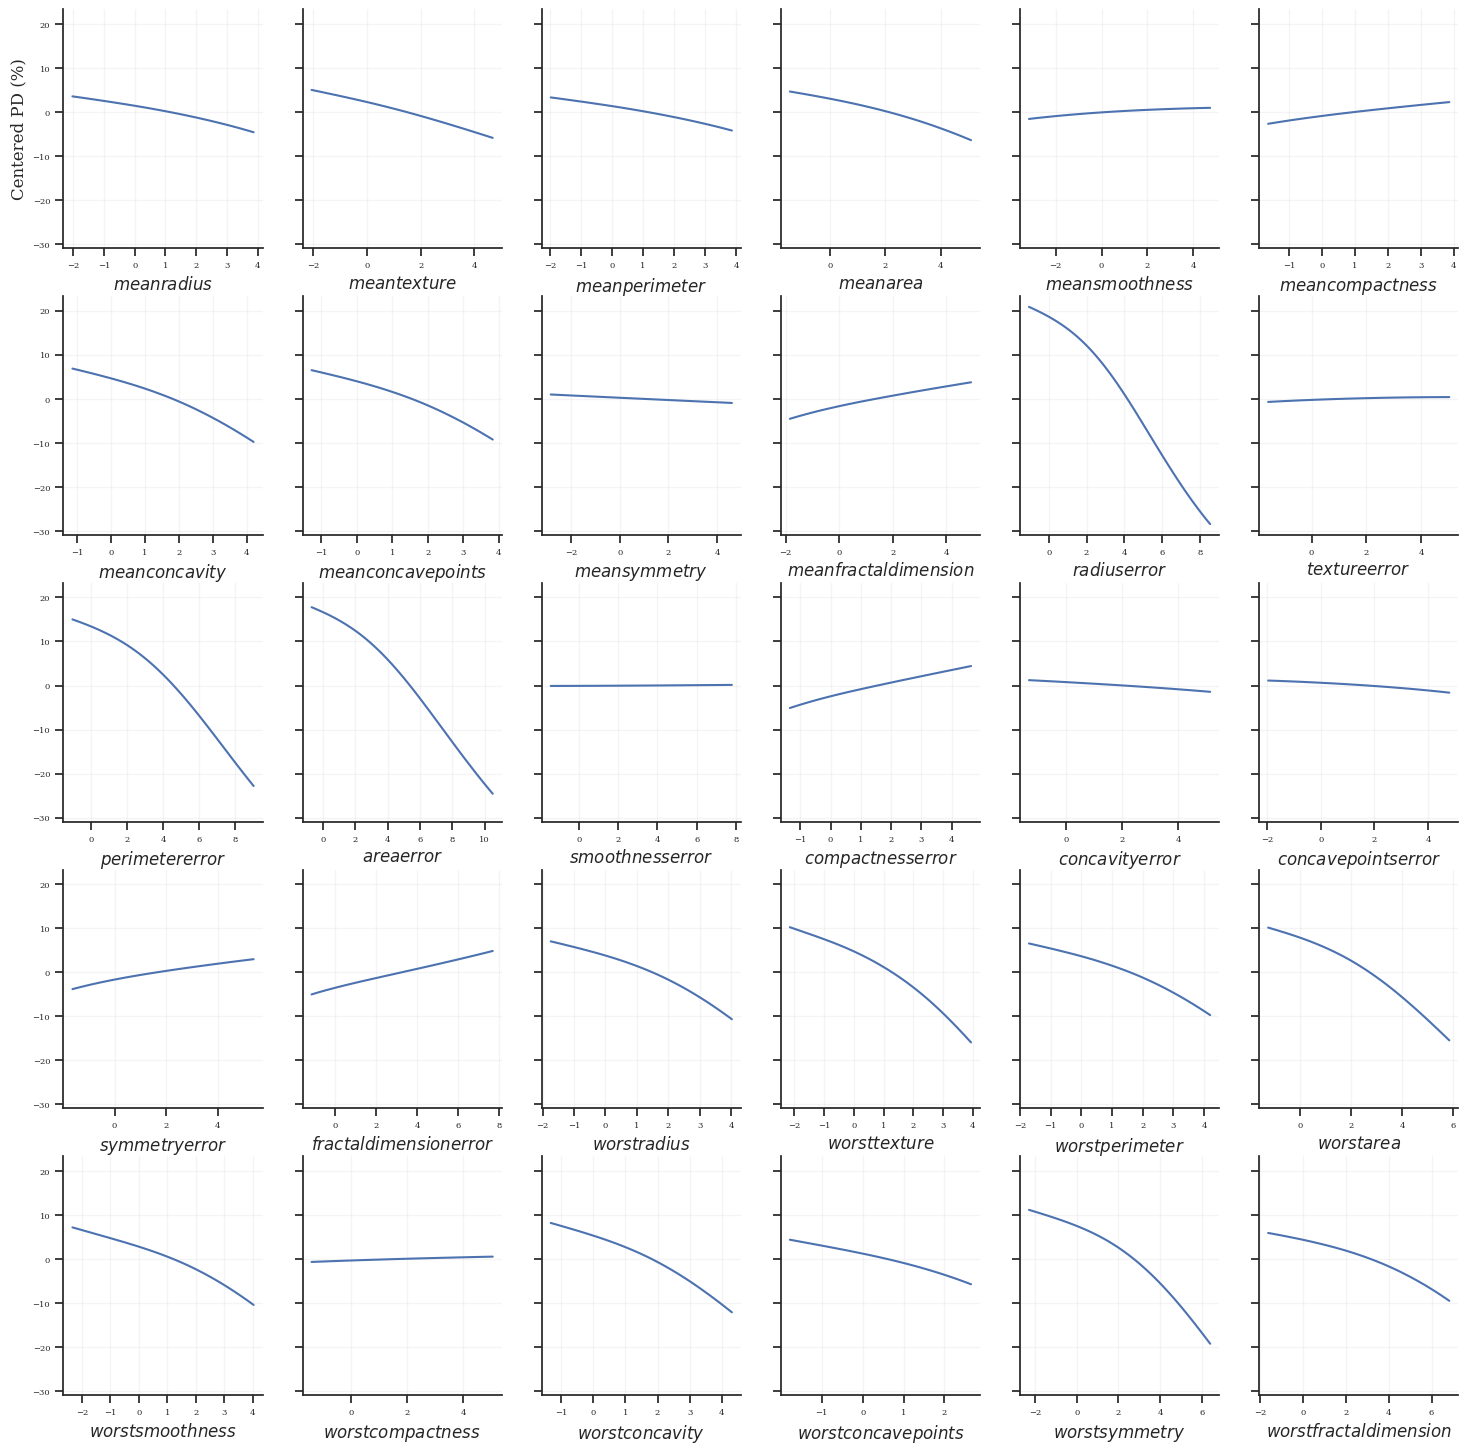

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


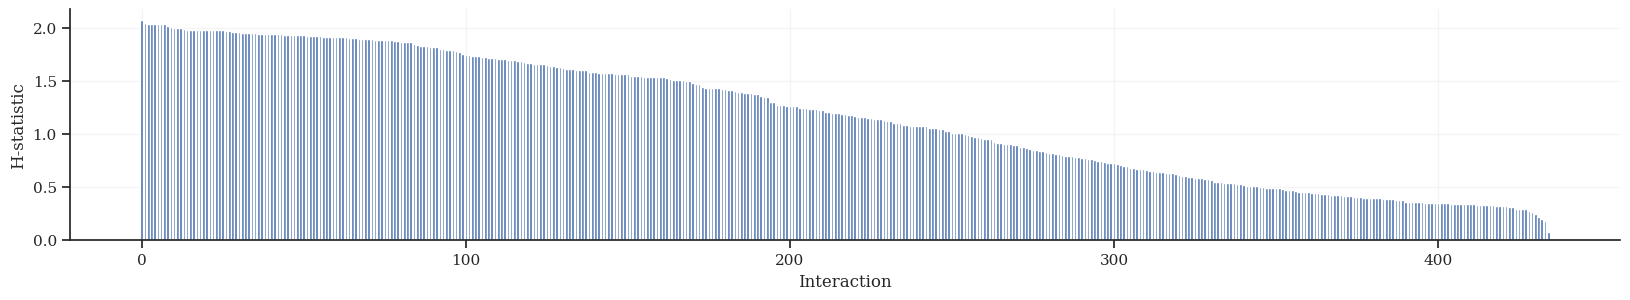

In [ ]:
# Plot 1D PDP
n_feat = len(f_names)
n_rows = 5
n_cols = n_feat//n_rows
fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 18), sharey=True)
for ifeat, fn in enumerate(f_names):
    icol = np.mod(ifeat, n_cols)
    irow = ifeat//n_cols
    x = pd_1d_ds[f'{fn}__bin_values'].to_numpy().flatten()
    y = pd_1d_ds[f'{fn}__svc__pd'].to_numpy().flatten()
    axs[irow, icol].plot(x, 100*y)
    axs[irow, icol].grid(alpha=0.2)
    axs[irow, icol].set_xlabel(f'${fn}$')
    if ifeat == 0:
        axs[irow, icol].set_ylabel(f'Centered PD (%)')
if save_figs:
    plt.savefig('./images/pdp_1d.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/pdp_1d.eps', bbox_inches='tight', facecolor='white')
plt.show()

# Plot Friedman's H-statistic
rank = [f"({interaction.split('__')[0]})*({interaction.split('__')[1]})" for interaction in list(hstat_results['hstat_rankings__svc'].to_numpy())]#[-40:]
val = hstat_results['hstat_scores__svc'].to_numpy().flatten()#[-40:]
plt.figure(figsize=(20,3))
plt.bar(np.arange(len(val)), val)
plt.tick_params(axis='both', which='major', labelsize=11)
plt.grid(alpha=0.2)
plt.xlabel('Interaction')
plt.ylabel('H-statistic')
if save_figs:
    plt.savefig('./images/h-statistic.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/h-statistic.eps', bbox_inches='tight', facecolor='white')
plt.show()

# Calculate local explanations with SHAP

In [ ]:
explainer = shap.Explainer(model.decision_function, X_test_scale, feature_names=f_names)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test_scale)

PermutationExplainer explainer: 115it [00:10,  1.74s/it]                         


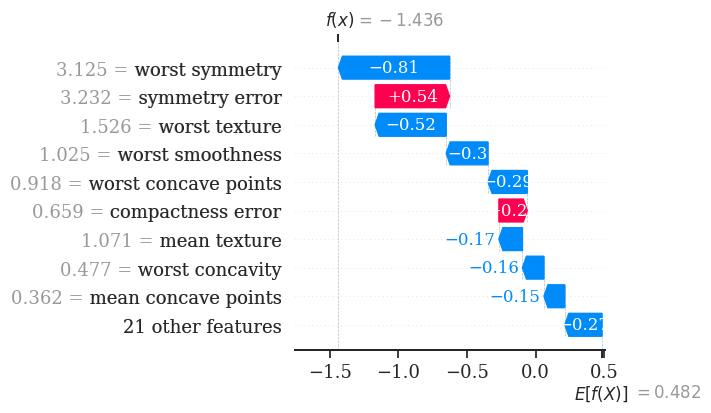

In [ ]:
ax = shap.plots.waterfall(shap_values[neg_ind], show=False, max_display=10)
plt.gcf().set_size_inches(4, 4)
plt.show()

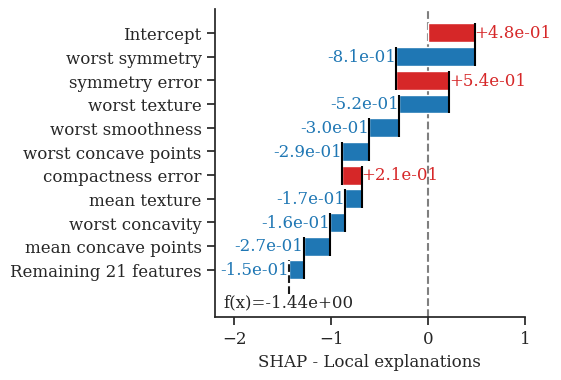

In [17]:
sort_order = np.flip(np.argsort(np.abs(shap_values[neg_ind].values)))
n_show = 9
remainder = shap_values[neg_ind].values[sort_order][n_show:].sum()
fig = waterfall(np.insert(np.insert(shap_values[neg_ind].values[sort_order][:n_show], 0, shap_values[neg_ind].base_values), -1, remainder),
          labels=['Intercept'] + explainer.feature_names[sort_order][:n_show].tolist() + [f'Remaining {len(explainer.feature_names)-n_show} features'], 
          show=False, show_values=True, show_sum=True, xlim=[-2.2, 1], figsize=(4,4))
# fig.gca
fig.gca().tick_params(axis='both', labelsize=12)
fig.gca().set_xlabel('SHAP - Local explanations')
if save_figs:
    plt.savefig('./images/local_shap_same_format.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/local_shap_same_format.eps', bbox_inches='tight', facecolor='white')
plt.show()